In [1]:
#|default_exp sadspheres
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics'
import diffusion_curvature

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
# from diffusion_curvature.core import *
from diffusion_curvature.utils import *
# from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

# Saddle Sphere Ablations
> Little brother to the Curvature Colosseum

This is a dataset intended to measure the sign discrimination ability of diffusion curvature and other curvature methods. The dataset consists of different samplings of saddles and spheres with varying intensities of curvature and in varying dimensions. There's also the possibility of adding noise. This notebook implements a class which creates this dataset with specified parameters as well as convenience functions which can be used for testing it and visualizing the results.

# Implementation

Because of the specialized purpose of this dataset, we're wrapping it in a special class, which allows the dataset to evaluate its own fidelity in embeddings.

It works like this:
1. Instatiate the class, supply the dimensions, and noise level, and it will create all of the graphs.
2. To run curvature computations on these graphs, you can extract them directly -- or, you can use the dataset as an *iterator*, loop through, run your own logic within, then run an 'update' function to store the result.
3. Afterwards, you can use the built in methods for visualizing and getting metrics on the performance.

In [2]:
#|export
from diffusion_curvature.core import get_adaptive_graph
from diffusion_curvature.datasets import rejection_sample_from_saddle, sphere, plane
from diffusion_curvature.self_evaluating_datasets import SelfEvaluatingDataset, metric
from fastcore.all import *
import xarray as xr
import inspect
import pandas as pd

import sklearn
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt


class SadSpheres(SelfEvaluatingDataset):
    def __init__(self,
                 dimension:list = [2], # Dimension of saddles and spheres. If a list is supplied, computed sadspheres for each
                 num_pointclouds = 100, # num pointclouds per dataset per dimension
                 num_points = 2000, # num points per pointclouds
                 noise_level = 0, # from 0 to 1. 1 is all noise.
                 include_planes = False, # if True, includes randomly sampled planes as a sanity check.
                ):
        store_attr()
        if isinstance(dimension, int):
            dimension = [dimension]

        
        datalist = []
        names = []
        
        for d in dimension:
            for i in range(num_pointclouds):
                X_saddle, ks_saddle = rejection_sample_from_saddle(self.num_points, d)
                datalist.append(
                    { 'X' : X_saddle, 'ks' : ks_saddle, 'd':d}
                )
                names.append(f'{d}-Saddle')
                
                X_sphere, ks_sphere = sphere(self.num_points, d)
                datalist.append(
                    { 'X' : X_sphere, 'ks' : ks_sphere[0], 'd':d}
                )
                names.append(f'{d}-Sphere')

                if self.include_planes:
                    X_plane = plane(self.num_points, d) 
                    X_plane = np.hstack([X_plane, np.zeros(self.num_points)[:,None]])
                    datalist.append(
                        { 'X' : X_plane, 'ks' : 0, 'd':d}
                    )
                    names.append(f'{d}-Plane')

            super().__init__(
                datalist, names, ['ks']
            )

                
    def get_item(self, idx):
        return self.DS[idx].obj['X']

    def get_truth(self, result_name, idx):
        truth = self.DS[idx].obj['ks']
        return truth

    def plot_by_dimension(self):
        names = self.names
        labels = self.labels['ks']
        # Extract unique dimensions
        dimensions = sorted(set(name[0] for name in names))
        
        # Number of methods
        methods = list(labels.keys())
        
        # Create a grid of plots
        fig, axs = plt.subplots(len(dimensions), len(methods), figsize=(5 * len(methods), 5 * len(dimensions)))
        if len(dimensions) == 1 or len(methods) == 1:
            axs = np.array(axs).reshape(len(dimensions), len(methods))
        
        # Define a color map based on unique dataset names without dimension prefix
        unique_names = sorted(set(name[2:] for name in names))  # Strip dimension prefix
        colors = plt.cm.get_cmap('viridis', len(unique_names))
        name_to_color = {name: colors(i) for i, name in enumerate(unique_names)}  # Correct mapping
        
        # Plotting
        for i, dim in enumerate(dimensions):
            for j, method in enumerate(methods):
                # Filter data for the current dimension
                data = [(labels[method][k], name[2:]) for k, name in enumerate(names) if name.startswith(dim)]  # Use name without prefix
        
                # Define bins for histogram
                all_values = [val for val, _ in data]
                bins = np.linspace(min(all_values), max(all_values), 51)  # 50 bins
        
                # Create histogram for each dataset
                ax = axs[i, j]
                for label in unique_names:
                    dataset_values = [val for val, name in data if name == label]  # Compare without dimension prefix
                    if dataset_values:  # Check if there are any values for this dataset
                        counts, _ = np.histogram(dataset_values, bins=bins)
                        bin_centers = 0.5 * (bins[:-1] + bins[1:])
                        ax.bar(bin_centers, counts, width=(bins[1] - bins[0]) * 0.9, color=name_to_color[label], label=label, alpha=0.75)
        
                ax.set_title(f'Dimension {dim} - {method}')
                ax.set_xlabel('Value Range')
                ax.set_ylabel('Count')
                if i == 0 and j == 0:  # Add legend only to the first subplot for clarity
                    ax.legend(title='Dataset Name')
        
        # Adjust layout
        plt.tight_layout()
        plt.show()
        

    

    @metric
    def pearson_r(self, a, b):
        return scipy.stats.pearsonr(a,b)[0]

    @metric
    def sign_score(self, 
                   a, # prediction
                   b # target
                  ):
        a = np.array(a)
        b = np.array(b)
        # measures classification accuracy of signs
        # First, get rid of zeros in ground truth curvatures; we don't want to classify the planes.
        nz = np.nonzero(b)[0]
        nonzero_preds = np.sign(a[nz])
        nonzero_targets = np.sign(b[nz])
        acc = np.sum((nonzero_preds == nonzero_targets).astype(int))/len(nz)
        return acc
        
            


In [19]:
#|export
from diffusion_curvature.core import get_adaptive_graph
from diffusion_curvature.datasets import rejection_sample_from_saddle, sphere, plane
from fastcore.all import *
import xarray as xr
import inspect
import pandas as pd

import sklearn
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

def metric(func):
    setattr(func, 'tag', 'metric')
    return func

class SadSpheres():
    def __init__(self,
                 dimension:list = 2, # Dimension of saddles and spheres. If a list is supplied, computed sadspheres for each
                 num_pointclouds = 100, # num pointclouds to make in total
                 num_points = 2000, # num points per pointclouds
                 noise_level = 0, # from 0 to 1. 1 is all noise.
                 include_planes = False, # if True, includes randomly sampled planes as a sanity check.
                ):
        store_attr()
        self.DS = xr.Dataset()
        self.idx = -1
        self.dnum = 3 if self.include_planes else 2
        if isinstance(dimension, list):
            dimensions = dimension
        else:
            dimensions = [dimension]
        for d in dimensions:
            for i in range(num_pointclouds//self.dnum):
                X_saddle, ks_saddle = rejection_sample_from_saddle(self.num_points, self.dimension)
                self.DS[self.dnum*i] = xr.DataArray(X_saddle, dims=['n', 'd'], attrs={'ks':ks_saddle, 'name':'Saddle'})
                X_sphere, ks_sphere = sphere(self.num_points, self.dimension)
                self.DS[self.dnum*i+1] = xr.DataArray(X_sphere, dims=['n', 'd'], attrs={'ks':ks_sphere[0], 'name':'Sphere'})
                if self.include_planes:
                    X_plane = plane(self.num_points, self.dimension) 
                    X_plane = np.hstack([X_plane, np.zeros(self.num_points)[:,None]])
                    self.DS[self.dnum*i + 2] = xr.DataArray(X_plane, dims=['n', 'd'], attrs = {'ks':0, 'name':'Plane'})
    
    def __iter__(self):
        return self

    def __len__(self):
        return len(self.DS)

    def __next__(self):
        self.idx += 1
        if self.idx >= self.__len__():
            raise StopIteration
        result = self.DS[self.idx].to_numpy()
        return result

    def update(self,
               result,
               method_name='computed'):
        """
        Store the result of the curvature computation by passing the computed curvature of the center (first) point.
        """
        self.DS[self.idx].attrs[method_name] = result

    def compute_metrics(self):
        self._aggregate_labels()
        metrics = self._get_metrics()
        self.metric_table = {}
        for metric in metrics:
            self.metric_table[metric.__name__] = {}
            for method_name in self.method_names:
                self.metric_table[metric.__name__][method_name] = self.compute(metric=metric, method_name=method_name)
        self.metric_table = pd.DataFrame(self.metric_table)
            
    def compute(self, metric, method_name):
        # Overwrite this class with your logic. It implements the computation of a single metric for a single method
        return metric(self.labels[method_name], self.labels['ks'])
    

    def _aggregate_labels(self):
        self.method_names = list(self.DS.data_vars[0].attrs.keys())
        self.method_names.remove('name')
        self.labels = {}
        for m in self.method_names:
            self.labels[m] = np.array([self.DS.data_vars[i].attrs[m] for i in range(self.__len__())])

    def plot(self, title = None):
        if title is None: title = f"In dimension {self.dimension}"
        # for each computed method on this dataset, we plot the histogram of saddles vs spheres
        self._aggregate_labels()
        # get the idxs for each type of dataset
        dataset_names = [self.DS.data_vars[i].attrs['name'] for i in range(len(self.DS))]
        unique_names = list(set(dataset_names))
        idxs_by_name = {n: [i for i, name in enumerate(dataset_names) if name == n] for n in unique_names}        
        for m in self.method_names: 
            if m != 'ks' and m != 'name':
                for dname in unique_names:
                    plt.hist(self.labels[m][idxs_by_name[dname]], bins=50, label = dname, edgecolor='none', linewidth=5)
                plt.legend()
                plt.xlabel(m)
                plt.title(title)
                plt.show()

    def table(self):
        self.compute_metrics()
        return self.metric_table

    def _get_metrics(self):
        tagged_functions = []
        for name, member in inspect.getmembers(self, predicate=inspect.ismethod):
            if hasattr(member, 'tag') and getattr(member, 'tag') == 'metric':
                tagged_functions.append(member)
        return tagged_functions

    @metric
    def pearson_r(self, a, b):
        return scipy.stats.pearsonr(a,b)

    @metric
    def sign_score(self, 
                   a, # prediction
                   b # target
                  ):
        print(a, b)
        # measures classification accuracy of signs
        # First, get rid of zeros in ground truth curvatures; we don't want to classify the planes.
        nz = np.nonzero(b)[0]
        print(nz)
        nonzero_preds = np.sign(a[nz])
        nonzero_targets = np.sign(b[nz])
        acc = np.sum((nonzero_preds == nonzero_targets).astype(int))/len(nz)
        return acc
        
        
    

# Tests

In [4]:
from diffusion_curvature.core import *
from diffusion_curvature.kernels import *

In [ ]:
SS = SadSpheres(
    dimension = [2,3,4,5], # Dimension of saddles and spheres
    num_pointclouds = 30, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=True,
)
graph_former = partial(get_curvature_agnostic_graph,k=2, neighbor_scale=1)
for X in tqdm(SS):
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former = graph_former,
        points_per_cluster=None, # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim = SS.DS[SS.idx-1].obj['d'], t = 25)
    SS.update(ks[0], method_name="Diffusion Entropic Curvature")
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Ollivier",
        graph_former = graph_former,
        points_per_cluster=None, # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim = SS.DS[SS.idx-1].obj['d'], t = 25)
    SS.update(ks[0], method_name="Diffusion Wasserstein Curvature")

  0%|          | 0/360 [00:00<?, ?it/s]

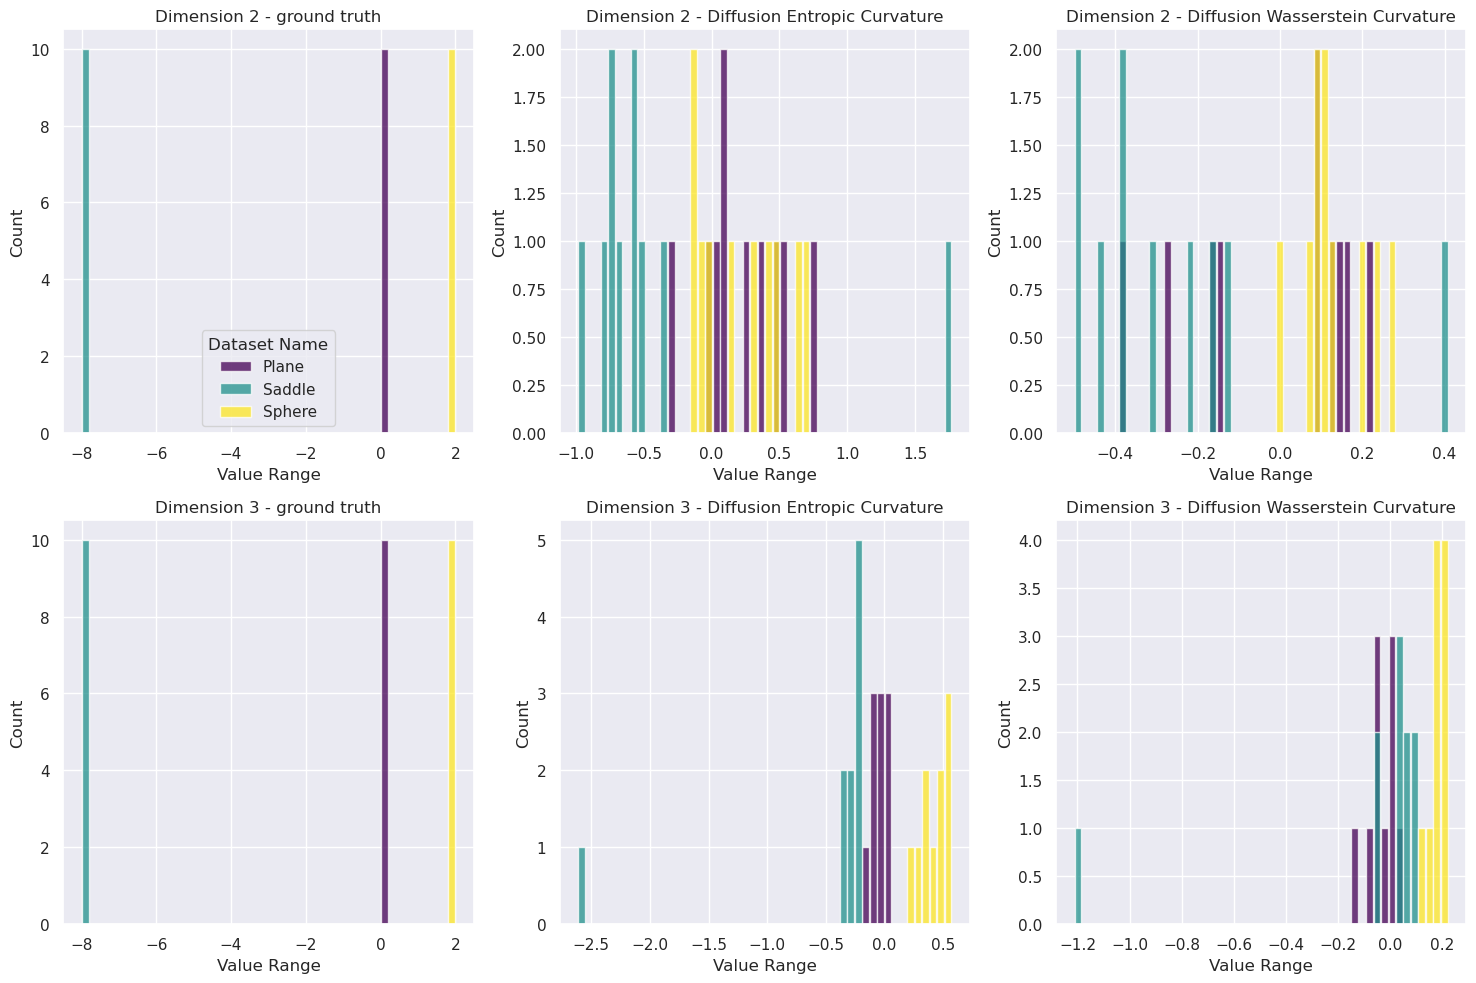

In [65]:
# globally
SS.plot_by_dimension()

In [66]:
ted = SS.table()

ks
                                 pearson_r  sign_score
ground truth                      1.000000       1.000
Diffusion Entropic Curvature      0.573444       0.875
Diffusion Wasserstein Curvature   0.499734       0.775


In [39]:
names = SS.names

In [47]:
labels =SS.labels['ks']

In [48]:
labels

{'ground truth': [-8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0,
  -8.0,
  2.0,
  0],
 'Diffusion Entropic Curvature': [Array(1.6631422, dtype=float32),
  Array(0.17632675, dtype=float32),
  Array(0.10452843, dtype=float32),
  Array(-0.68403625, dtype=float32),
  Array(-0.235538, dtype=float32),
  Array(-0.15010071, dtype=float32),
  Array(-0.385139, dtype=float32),
  Array(-0.48749542, dtype=float32),
  Array(-0.31570435, dtype=float32),
  Array(-0.88182926, dtype=float32),
  Array(-0.05572653, dtype=float32),
  Array(-0.01179457, dtype=float32),
  Array(-0.75139, dtype=float32),
  Array(-0.11824274, dtype=float32),
  Array(-0.14518881, dtype=float32),
  Array

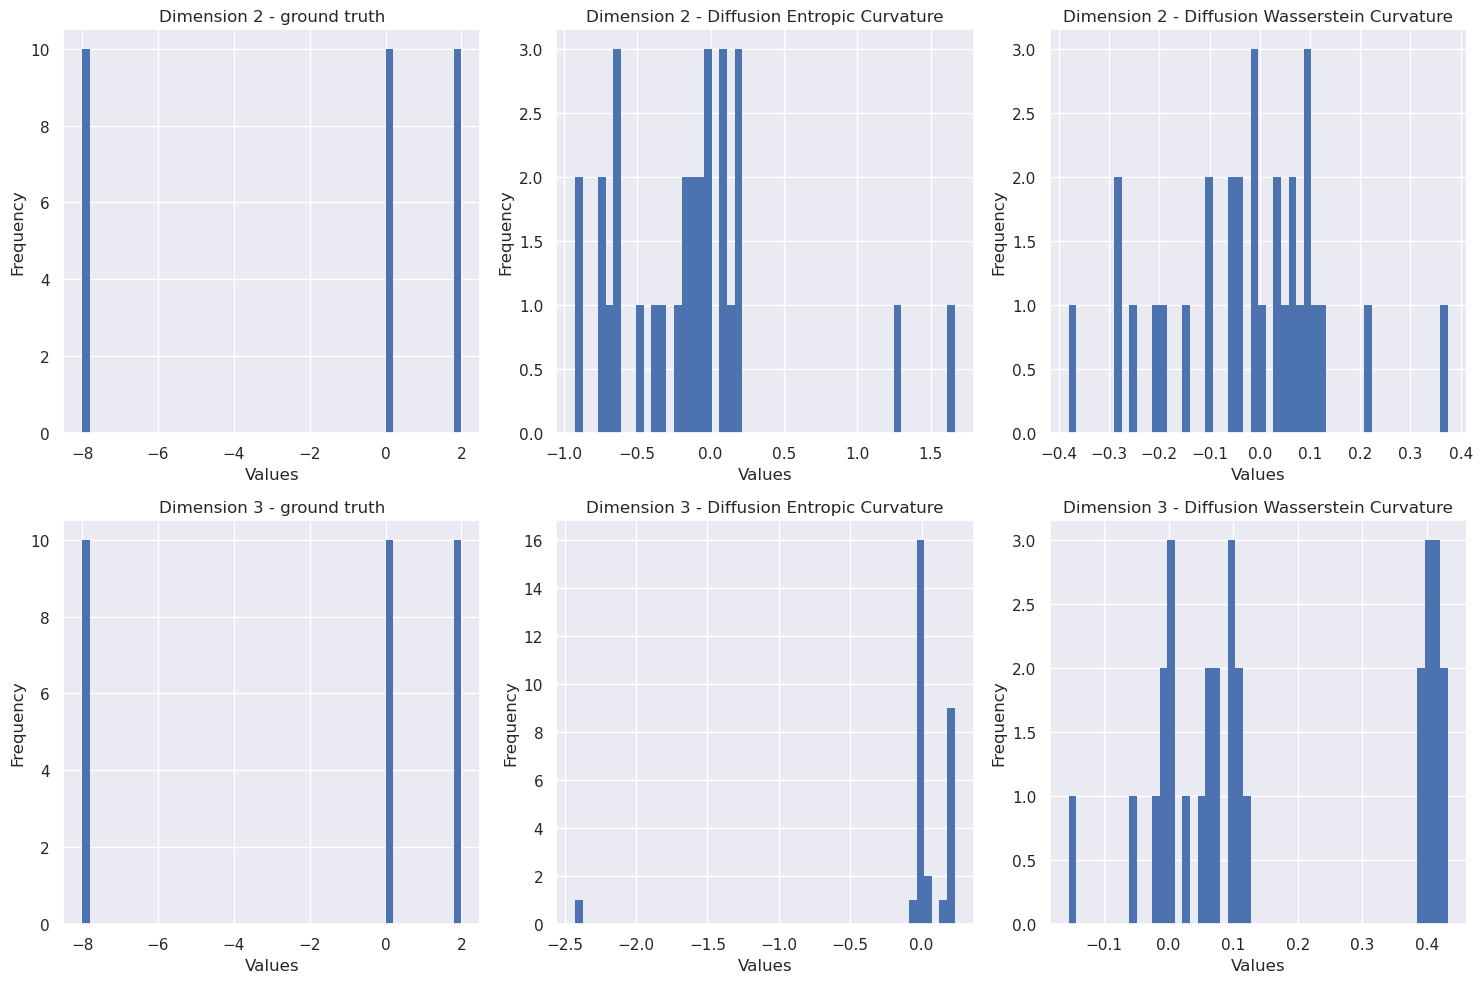

In [53]:
# Step 1: Extract unique dimensions
dimensions = sorted(set(name[0] for name in names))

# Step 2: Number of methods
methods = list(labels.keys())

# Step 3: Create a grid of plots
fig, axs = plt.subplots(len(dimensions), len(methods), figsize=(5 * len(methods), 5 * len(dimensions)))
if len(dimensions) == 1 or len(methods) == 1:
    axs = np.array(axs).reshape(len(dimensions), len(methods))

# Step 4: Plot histograms
for i, dim in enumerate(dimensions):
    for j, method in enumerate(methods):
        # Filter data for the current dimension
        local_names = [[name for k, name in enumerate(names) if name.startswith(dim)]]
        data = [labels[method][k] for k, name in enumerate(names) if name.startswith(dim)]

        # Plot histogram
        ax = axs[i, j]
        ax.hist(data, bins=50, label = local_names, edgecolor='none', linewidth=5)
        ax.set_title(f'Dimension {dim} - {method}')
        ax.set_xlabel('Values')
        ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

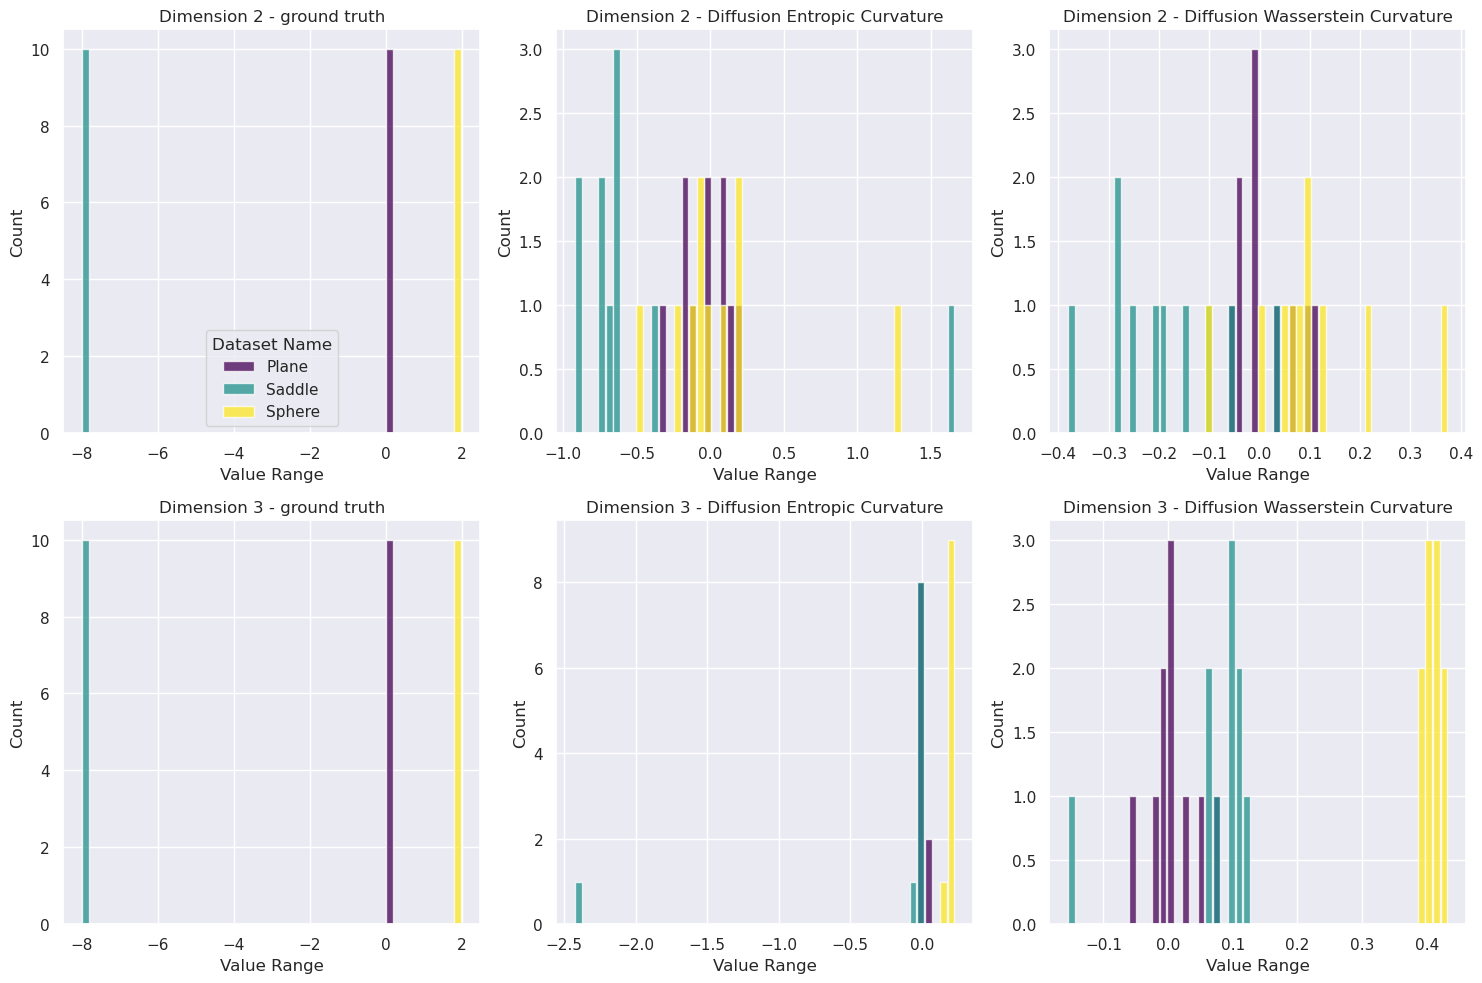

In [60]:

# Extract unique dimensions
dimensions = sorted(set(name[0] for name in names))

# Number of methods
methods = list(labels.keys())

# Create a grid of plots
fig, axs = plt.subplots(len(dimensions), len(methods), figsize=(5 * len(methods), 5 * len(dimensions)))
if len(dimensions) == 1 or len(methods) == 1:
    axs = np.array(axs).reshape(len(dimensions), len(methods))

# Define a color map based on unique dataset names without dimension prefix
unique_names = sorted(set(name[2:] for name in names))  # Strip dimension prefix
colors = plt.cm.get_cmap('viridis', len(unique_names))
name_to_color = {name: colors(i) for i, name in enumerate(unique_names)}  # Correct mapping

# Plotting
for i, dim in enumerate(dimensions):
    for j, method in enumerate(methods):
        # Filter data for the current dimension
        data = [(labels[method][k], name[2:]) for k, name in enumerate(names) if name.startswith(dim)]  # Use name without prefix

        # Define bins for histogram
        all_values = [val for val, _ in data]
        bins = np.linspace(min(all_values), max(all_values), 51)  # 50 bins

        # Create histogram for each dataset
        ax = axs[i, j]
        for label in unique_names:
            dataset_values = [val for val, name in data if name == label]  # Compare without dimension prefix
            if dataset_values:  # Check if there are any values for this dataset
                counts, _ = np.histogram(dataset_values, bins=bins)
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                ax.bar(bin_centers, counts, width=(bins[1] - bins[0]) * 0.9, color=name_to_color[label], label=label, alpha=0.75)

        ax.set_title(f'Dimension {dim} - {method}')
        ax.set_xlabel('Value Range')
        ax.set_ylabel('Count')
        if i == 0 and j == 0:  # Add legend only to the first subplot for clarity
            ax.legend(title='Dataset Name')

# Adjust layout
plt.tight_layout()
plt.show()


In [45]:
methods

['ks']

In [44]:
labels['Diffusion Entropic Curvature']

KeyError: 'Diffusion Entropic Curvature'

In [ ]:
# sync changes to the library
from IPython.display import display, Javascript
import time
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(2)
!pixi run nbsync

<IPython.core.display.Javascript object>

 WARN pixi::project::manifest: BETA feature `[pypi-dependencies]` enabled!

Please report any and all issues here:

	https://github.com/prefix-dev/pixi.

Turn this warning off by setting the environment variable `PIXI_BETA_WARNING_OFF` to `true`.

✨ Pixi task (default): nbdev_export
⠁ activating environment                                                                 